In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import anndata as ad
import scanpy as sc
import scipy.stats as stats
import diffxpy.api as de
import gseapy as gp

from scripts import constants
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans

from contrastive_vi.model.cvae import CVAEModel

from typing import Any, List

Global seed set to 0
During startup - Warning messages:
1: package ‘methods’ was built under R version 3.6.1 
2: package ‘datasets’ was built under R version 3.6.1 
3: package ‘utils’ was built under R version 3.6.1 
4: package ‘grDevices’ was built under R version 3.6.1 
5: package ‘graphics’ was built under R version 3.6.1 
6: package ‘stats’ was built under R version 3.6.1 


In [2]:
performance_df = pd.read_csv(
    os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        "performance_summary.csv",
    )
)

performance_df = performance_df.melt(
    id_vars=[
        "dataset",
        "method",
        "latent_size",
        "seed",
    ],
    value_vars=[
        "num_epochs",
        "silhouette",
        "calinski_harabasz",
        "davies_bouldin",
        "adjusted_random_index",
        "adjusted_mutual_info",
    ],
).rename(columns={"variable": "metric"})

In [3]:
performance_df = performance_df[
    (performance_df["dataset"].isin(["zheng_2017", "haber_2017", "mcfarland_2020"]))
    & (performance_df["metric"].isin(["silhouette", "adjusted_random_index", "adjusted_mutual_info"]))
]

In [4]:
performance_df = performance_df[
    (performance_df["method"].str.contains("cPCA"))
    | (performance_df["method"].str.contains("cVAE"))
    | (performance_df["method"].str.contains("contrastiveVI"))
]

In [5]:
performance_df = pd.concat(
    [
        performance_df,
        performance_df["method"].str.split("_", expand=True).rename(
            columns={0: "contrastive_method", 1: "normalization_method"}
        ),
    ],
    axis=1,
)

In [6]:
def format_dataset_name(name):
    if name == "zheng_2017":
        formatted_name = "Zheng et al. 2017"
    elif name == "haber_2017":
        formatted_name = "Haber et al. 2017"
    elif name == "mcfarland_2020":
        formatted_name = "McFarland et al. 2020"
    else:
        formatted_name = name
    return formatted_name


def format_metric_name(name):
    if name == "silhouette":
        formatted_name = "Silhouette"
    elif name == "adjusted_random_index":
        formatted_name = "ARI"
    elif name == "adjusted_mutual_info":
        formatted_name = "AMI"
    else:
        formatted_name = name
    return formatted_name


def format_normalization_name(name):
    if "_tc" in name:
        formatted_name = name.replace("_tc", " with TC")
    elif "_tmm" in name:
        formatted_name = name.replace("_tmm", " with TMM")
    elif "_basics" in name:
        formatted_name = name.replace("_basics", " with BASiCS")
    elif "_scran" in name:
        formatted_name = name.replace("_scran", " with scran")
    else:
        formatted_name = name
    return formatted_name

In [7]:
datasets = [
    "Zheng et al. 2017",
    "Haber et al. 2017",
    "McFarland et al. 2020",
]
methods = ["cPCA", "cVAE"]
normalizations = [" with TC", " with TMM", " with scran", " with BASiCS"]
full_methods = [
    f"{method}{normalization}" for method in methods for normalization in normalizations
]
full_methods += ["contrastiveVI"]

In [8]:
performance_df["dataset"] = pd.Categorical(
    performance_df["dataset"].map(format_dataset_name),
    datasets,
)

performance_df["metric"] = pd.Categorical(
    performance_df["metric"].map(format_metric_name),
    ["Silhouette", "ARI", "AMI"],
)

performance_df["method"] = pd.Categorical(
    performance_df["method"].map(format_normalization_name),
    full_methods,
)

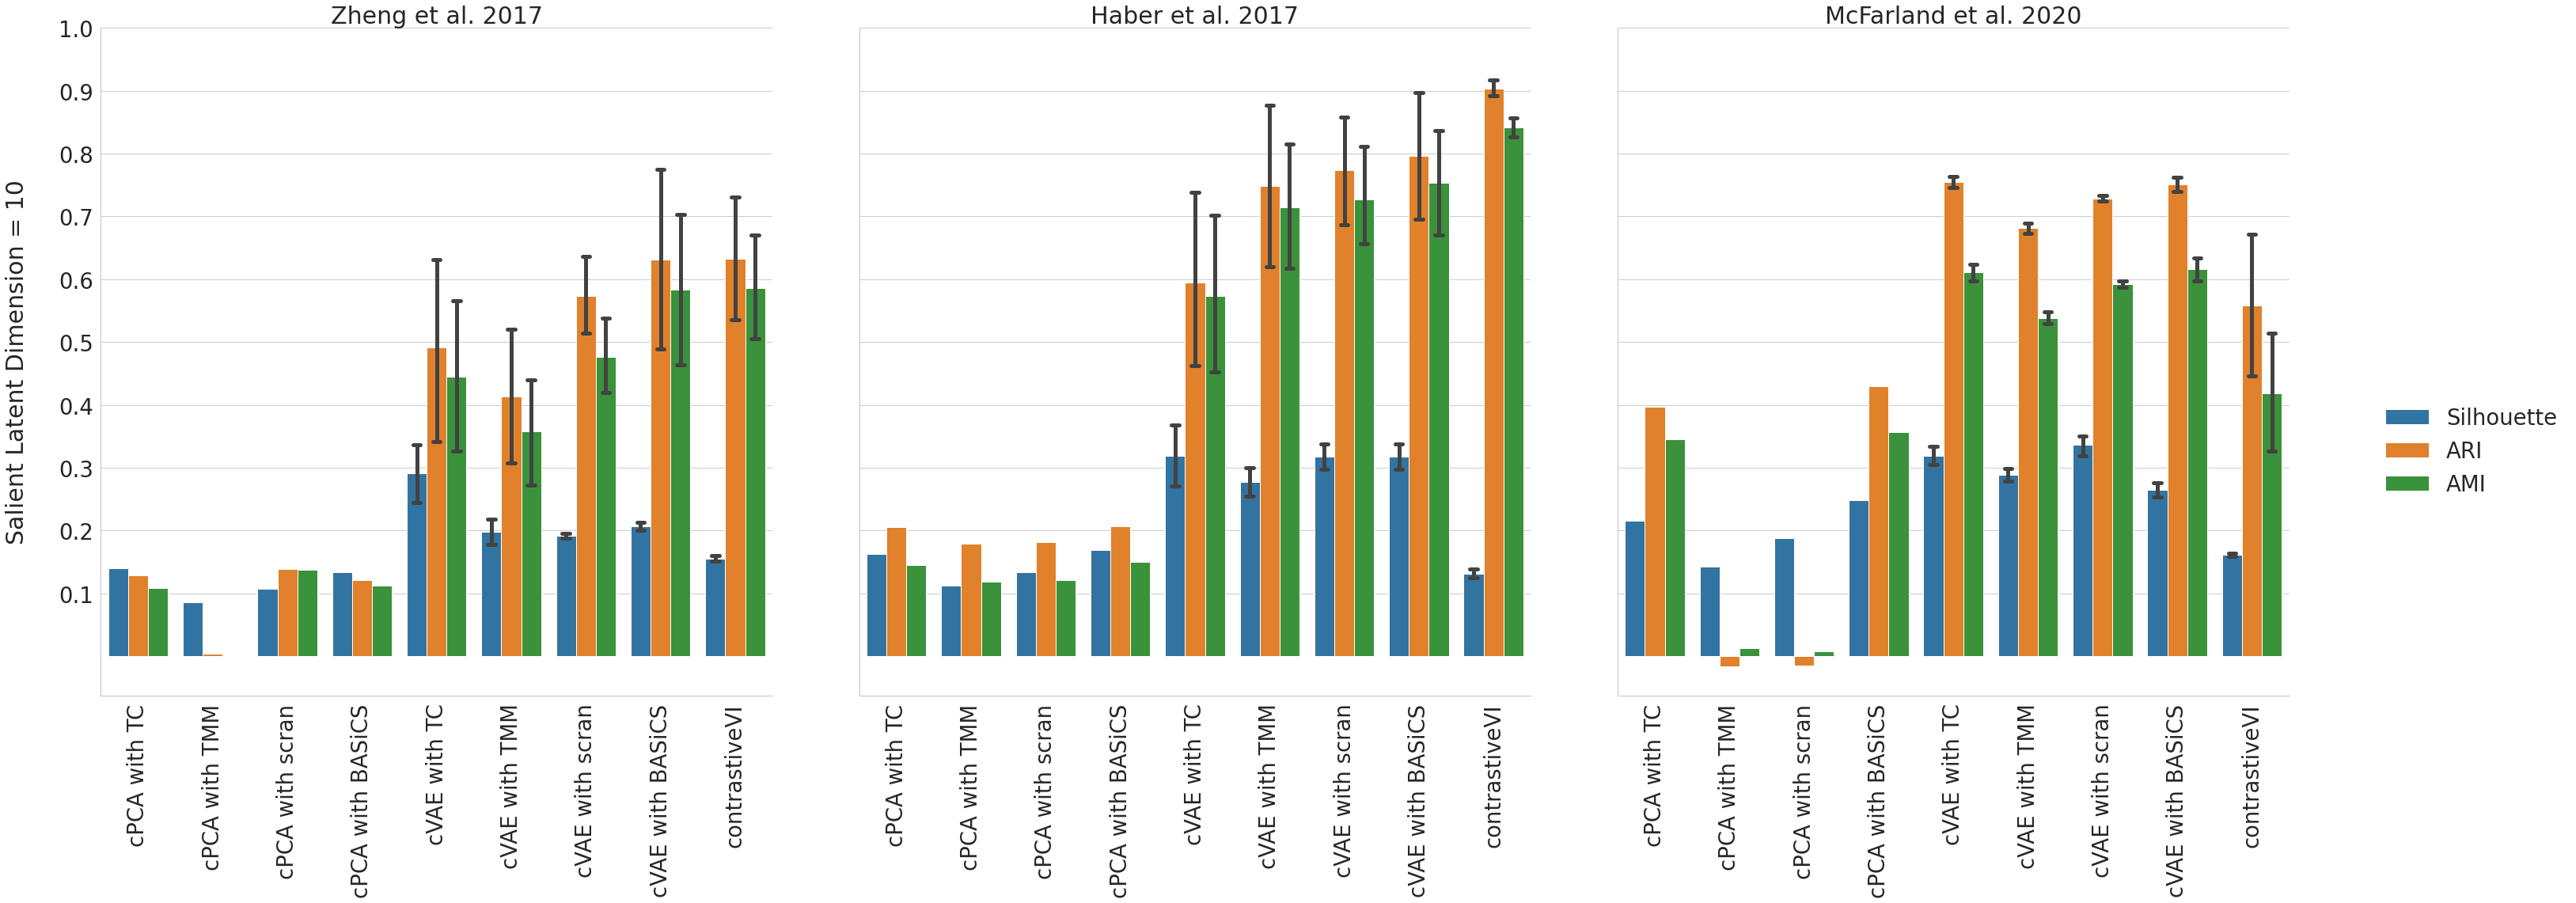

In [9]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
latent_size_list = [10]

for latent_size in latent_size_list:
    g = sns.FacetGrid(
        performance_df[performance_df["latent_size"] == latent_size],
        col="dataset",
        sharey=True,
        sharex=True,
        margin_titles=True,
        height=14,
        aspect=1,
    )
    g.map_dataframe(
        sns.barplot,
        x="method",
        y="value",
        hue="metric",
        ci=68.2,
        errwidth=5,
        capsize=0.10,
        palette=sns.color_palette("tab10"),
    )
    g.set_titles(
        col_template="{col_name}",
    )
    g.set_xticklabels(rotation=90)
    g.set(yticks=np.arange(0.1, 1.1, 0.1))
    g.set_axis_labels("\n", f"Salient Latent Dimension = {latent_size}\n")
    g.add_legend()

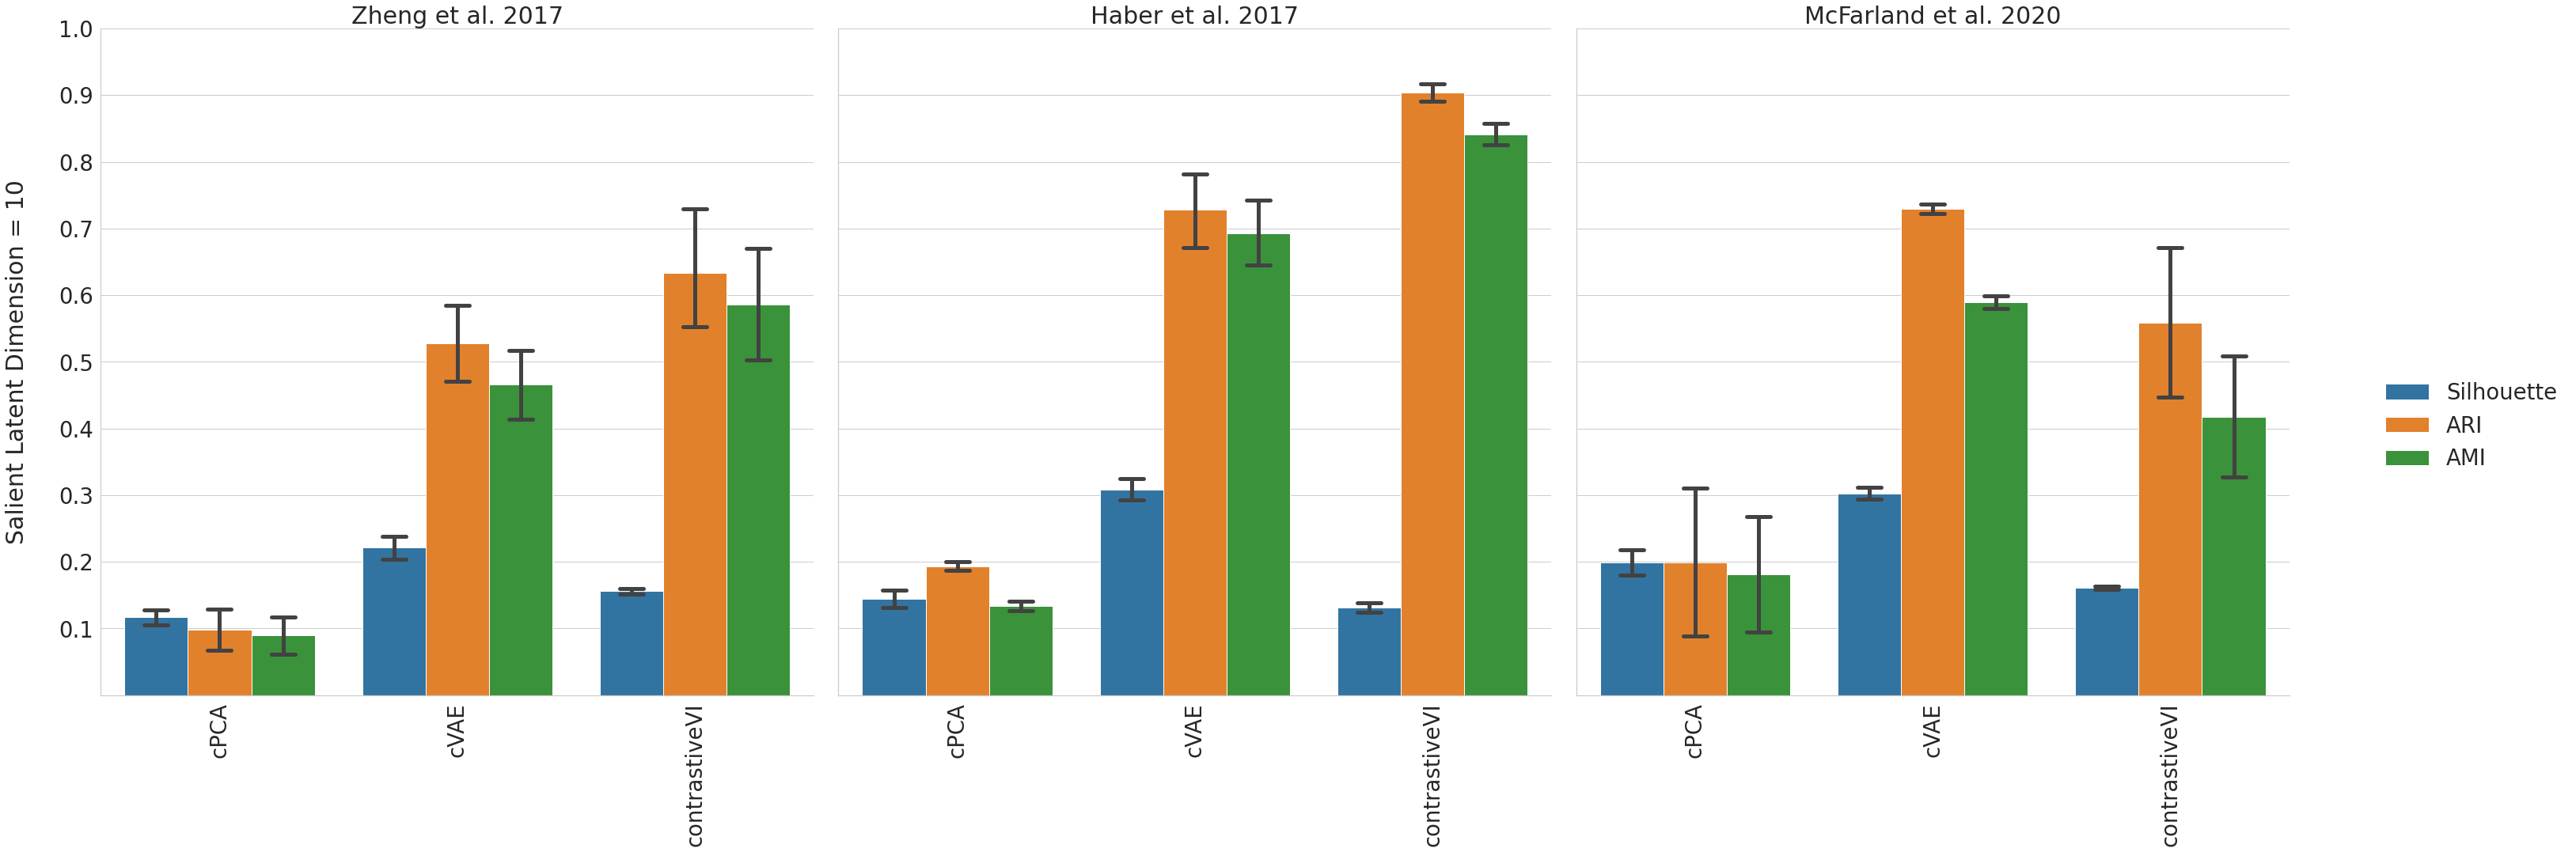

In [10]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
latent_size_list = [10]

for latent_size in latent_size_list:
    g = sns.FacetGrid(
        performance_df[performance_df["latent_size"] == latent_size],
        col="dataset",
        sharey=True,
        sharex=True,
        margin_titles=True,
        height=14,
        aspect=1,
    )
    g.map_dataframe(
        sns.barplot,
        x="contrastive_method",
        y="value",
        hue="metric",
        ci=68.2,
        errwidth=5,
        capsize=0.10,
        palette=sns.color_palette("tab10"),
    )
    g.set_titles(
        col_template="{col_name}",
    )
    g.set_xticklabels(rotation=90)
    g.set(yticks=np.arange(0.1, 1.1, 0.1))
    g.set_axis_labels("\n", f"Salient Latent Dimension = {latent_size}\n")
    g.add_legend()

In [11]:
def test_anova_across_normalization(
    data: pd.DataFrame,
    contrastive_method: str,
    latent_size: int,
    metric: str,
    dataset: str,
    normalization_list: List[str],
) -> float:
    sub_data = data[
        (data["contrastive_method"] == contrastive_method)
        & (data["latent_size"] == latent_size)
        & (data["metric"] == metric)
        & (data["dataset"] == dataset)
    ]
    value_list = [
        sub_data[
            sub_data["normalization_method"] == normalization
        ]["value"].to_numpy()
        for normalization in normalization_list
    ]
    results = stats.f_oneway(*value_list)
    return results.pvalue

In [12]:
for contrastive_method in ["cVAE"]:
    for latent_size in [10]:
        print(f"{contrastive_method} with latent size = {latent_size}")
        for dataset in performance_df["dataset"].unique():
            print(f"\tDataset: {dataset}")
            for metric in performance_df["metric"].unique():
                p_value = test_anova_across_normalization(
                    performance_df,
                    contrastive_method,
                    latent_size,
                    metric,
                    dataset,
                    constants.NORMALIZATION_LIST,
                )
                print(f"\t\t{metric} ANOVA p-value: {p_value}")
            print("")

cVAE with latent size = 10
	Dataset: McFarland et al. 2020
		Silhouette ANOVA p-value: 0.009231546772556968
		ARI ANOVA p-value: 0.0001349576050101813
		AMI ANOVA p-value: 0.004226705121383818

	Dataset: Zheng et al. 2017
		Silhouette ANOVA p-value: 0.1516539978238503
		ARI ANOVA p-value: 0.6348384396547677
		AMI ANOVA p-value: 0.5441840227092714

	Dataset: Haber et al. 2017
		Silhouette ANOVA p-value: 0.7979461378819244
		ARI ANOVA p-value: 0.6496958891610056
		AMI ANOVA p-value: 0.6259225999411495



In [13]:
# The overall goal is to show that there is some instability in the performance or biology discovery process
# of cVAE with varying normalization.

# Show that cVAE identifies different biology depending on different normalization.

# For each normalization,
# (1) Perform differential expression analysis.
# (2) Rank each gene's importance.
# (3) Find important pathways.

# Compare gene importance ranking across different normalization via rank correlation.
# Compare overlap of important pathways across normalization methods.

In [14]:
def differential_analysis(
    model_dir_list: List[str],
    target_adata: ad.AnnData,
    gene_id_map: pd.DataFrame,
    cluster_seed: int = 123,
) -> pd.DataFrame:
    de_result_list = []
    for index, model_dir in enumerate(model_dir_list):
        latent_rep = np.load(
            os.path.join(model_dir, "latent_representations.npy"),
        )
        latent_clusters = KMeans(n_clusters=2, random_state=cluster_seed).fit(latent_rep).labels_
        
        tmp_target_adata = target_adata.copy()
        tmp_target_adata.obs["cluster"] = latent_clusters.astype(str)
        
        de_result = de.test.t_test(data=tmp_target_adata, grouping="cluster")
        de_result = de_result.summary()
        
        de_result["ensembl_id"] = de_result["gene"]
        de_result = de_result.merge(gene_id_map, on="ensembl_id")
        de_result["index"] = index
        de_result_list.append(de_result)
    return pd.concat(de_result_list)

In [15]:
def jaccard_index(a: List[Any], b: List[Any]):
    set_a = set(a)
    set_b = set(b)
    intersection = set_a.intersection(set_b)
    union = set_a.union(b)
    return len(intersection) / len(union)

In [16]:
latent_size = 10
dataset = "mcfarland_2020"
contrastive_method = "cVAE"
split_key = constants.DATASET_SPLIT_LOOKUP[dataset]["split_key"]
background_value = constants.DATASET_SPLIT_LOOKUP[dataset]["background_value"]
seeds = constants.DEFAULT_SEEDS

In [17]:
gene_id_map = pd.read_table(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        dataset,
        "idasanutlin",
        "Idasanutlin_24hr_expt1",
        "genes.tsv",
    ),
    header=None,
)
gene_id_map = gene_id_map.rename(columns={0: "ensembl_id", 1: "gene_symbol"})

In [18]:
normalization_de_result = {}
normalization_de_mean_result = {}
normalization_deg_result = {}
normalization_enr_result = {}

for normalization in constants.NORMALIZATION_LIST:
    adata = sc.read_h5ad(
        os.path.join(
            constants.DEFAULT_DATA_PATH,
            f"{dataset}/preprocessed/adata_top_2000_genes_{normalization}.h5ad",
        )
    )
    target_indices = np.where(adata.obs[split_key] != background_value)[0]
    target_adata = adata[target_indices]
    target_gene_id_map = gene_id_map[
        gene_id_map["ensembl_id"].isin(target_adata.var.index)
    ]
    
    model_dir_list = [
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/{contrastive_method}_{normalization}",
            f"latent_{latent_size}",
            f"{seed}",
        )
        for seed in constants.DEFAULT_SEEDS
    ]
    de_result = differential_analysis(
        model_dir_list=model_dir_list,
        target_adata=target_adata,
        gene_id_map=target_gene_id_map,
    )
    de_result_mean = (
        de_result.groupby("gene_symbol", as_index=False).mean()
    )
    degs = de_result_mean[de_result_mean["qval"] < 0.05]["gene_symbol"].tolist()
    enr = gp.enrichr(
        gene_list=degs,
        gene_sets="KEGG_2016",
        organism="human",
        cutoff=0.05,
    )
    enr_results = enr.results
    enr_results = enr_results[enr_results["Adjusted P-value"] < 0.05]
    
    normalization_de_result[normalization] = de_result
    normalization_de_mean_result[normalization] = de_result_mean
    normalization_deg_result[normalization] = degs
    normalization_enr_result[normalization] = enr_results

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [19]:
compared_list = []
result_list = []
for norm_1 in constants.NORMALIZATION_LIST:
    for norm_2 in constants.NORMALIZATION_LIST:
        if norm_1 != norm_2:
            norm_set = {norm_1, norm_2}
            if norm_set not in compared_list:
                compared_list.append(norm_set)
                deg_jaccard = jaccard_index(
                    normalization_deg_result[norm_1],
                    normalization_deg_result[norm_2],
                )
                enr_jaccard = jaccard_index(
                    normalization_enr_result[norm_1]["Term"].tolist(),
                    normalization_enr_result[norm_2]["Term"].tolist()
                )
                norm_1_de_mean = normalization_de_mean_result[norm_1].sort_values(by="gene_symbol")
                norm_2_de_mean = normalization_de_mean_result[norm_2].sort_values(by="gene_symbol")
                spearman = stats.spearmanr(
                    norm_1_de_mean["pval"].tolist(),
                    norm_2_de_mean["pval"].tolist(),
                    nan_policy="omit",
                )
                
                
                result_list.append(
                    pd.DataFrame(
                        {
                            "norm_1": [norm_1],
                            "norm_2": [norm_2],
                            "deg_jaccard": [deg_jaccard],
                            "enr_jaccard": [enr_jaccard],
                            "spearman": [spearman.correlation],
                        }
                    )
                )
result = pd.concat(result_list)

In [20]:
result

,norm_1,norm_2,deg_jaccard,enr_jaccard,spearman
0,tc,tmm,0.766863,0.673077,0.826133
0,tc,scran,0.803934,0.723404,0.863158
0,tc,basics,0.884117,0.750000,0.948971
0,tmm,scran,0.899225,0.800000,0.968697
0,tmm,basics,0.802929,0.755102,0.882188
0,scran,basics,0.849297,0.702128,0.916775


In [21]:
all_degs = [
    set(normalization_deg_result[norm])
    for norm in constants.NORMALIZATION_LIST
]
all_terms = [
    set(normalization_enr_result[norm]["Term"].tolist())
    for norm in constants.NORMALIZATION_LIST
]

ovearll_deg_jaccard = len(
    all_degs[0].intersection(*all_degs[1:])) / len(all_degs[0].union(*all_degs[1:])
)

ovearll_enr_jaccard = len(
    all_terms[0].intersection(*all_terms[1:])) / len(all_terms[0].union(*all_terms[1:])
)

In [22]:
print(f"Overall DEG Jaccaard: {ovearll_deg_jaccard}")
print(f"Overall enriched term Jaccard: {ovearll_enr_jaccard}")

Overall DEG Jaccaard: 0.7209154481881754
Overall enriched term Jaccard: 0.5576923076923077
